# Сравнение интегралов

Быстрое преобразование Фурье против метода Симпсона

In [2]:
import numpy as np
from numpy import log, sqrt
from numpy import exp, linspace, fft, array, arange, pi
import matplotlib.pyplot as plt

In [3]:
# model parameters - we are going to evaluate a barrier put
T = 1
H_original = 90.0 # limit
K_original = 100.0 # strike
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
V0 = 0.316227766

delta_t = 1/100
r_premia = 10 # annual interest rate
r = log(r_premia/100 + 1)
q = 1.0/delta_t + r

sigma = V0
gamma = r - 0.5 * sigma**2 # Black-Scholes parameter, from a no-arbitrage condition

def psi(xi):
    return (sigma**2/2) * xi * xi - 1j*gamma*xi

## Фи-минус

$\phi^-_q(\xi)$ будут иметь вид:

$$ \phi^-_q(\xi) = exp[-i\xi F^-(0) - \xi^2 \hat{F}^-(\xi)] $$

$$ F^-(x) = 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty + i\omega_+}^{+\infty + i\omega_+} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta =$$

$$// \upsilon = \eta -i\omega_+ //$$

$$= 1_{[0,+\infty)}(x)(2\pi)^{-1} \int_{-\infty}^{+\infty} e^{ix(\upsilon+i\omega_+)} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) =  $$
$$= 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix\upsilon} \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2} d(\upsilon) $$
$$ \hat{F}^-(\xi) = \int_{-\infty}^{+\infty} e^{-ix\xi} F^-(x) dx $$

Вычислим значение подынтегральной части сразу в виде массива: $$intfunc_-(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_+))}{(\upsilon+i\omega_+)^2}, \upsilon \in \upsilon\_space$$

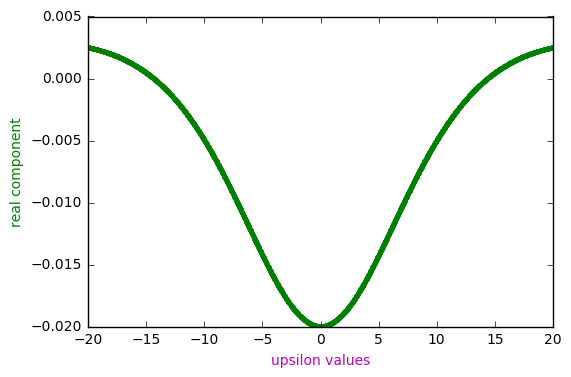

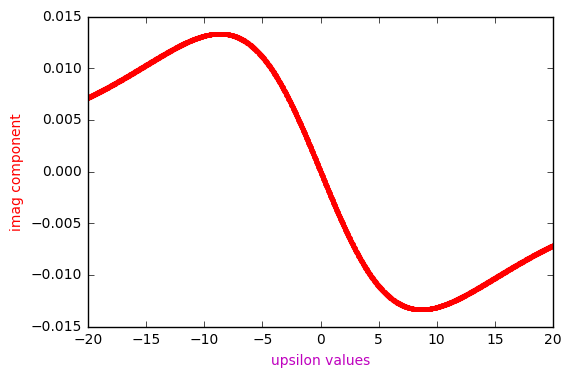

In [4]:
omega_plus = 15

def integrand_minus(upsilon_array):
    """
    принимает и возвращает массив длиной в степень двойки, исходя из логики дальнейшего использования
    """
    return np.array([log(q + psi(upsilon + 1j*omega_plus)) / (upsilon + 1j*omega_plus)**2 for upsilon in upsilon_array])

upsilon_M = 2**11
upsilon_space = np.linspace(-20.0, 20.0, num=upsilon_M, endpoint=False)

plt.plot(upsilon_space, integrand_minus(upsilon_space).real, 'g.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('real component', color='g')

plt.show()

plt.plot(upsilon_space, integrand_minus(upsilon_space).imag, 'r.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('imag component', color='r')

plt.show()

Особую ценность имеет изучение интеграла от этой функции в нуле (к нему сводятся $F(0)$). Разделив значение на $2*\pi$ будем получать то, что мы надеемся увидеть у более изощрённых методов в точке 0

$$ F^-(0) = \frac{1}{2\pi} \int_{-\infty}^{+\infty} intfunc_-(\upsilon) d\upsilon $$

Экспериментально отмечено, что при $\omega_+ = 10$ стабилизация в третьем знаке (0.021) наступает при $M = 2^{17}$ и разбросе точек в диапазоне (-32000, 32000) и потеряется там при $M = 2^{14}$ и диапазоне (-4000, 4000). Дальнейшее увеличение разбиения и интервала до $M = 2^{20}$ и диапазона до (-132000, 132000) может поднять значение до 0.022. Увенличение $\omega_+$ до 15 не сказывается на величине интеграла.

При $\omega_+ = 1$ стабилизация не наступает вовсе, а различия между методами вычисления интегралов становятся значительными, например, при  $M = 2^{15}$ и диапазоне (-16000, 16000)

Попробуем теперь взять меньший промежуток, но более детальное разбиение. Выведем также шаг

In [15]:
from scipy import integrate

upsilon_M = 2**25
upsilon_space = np.linspace(-10000, 10000, num=upsilon_M+1, endpoint=True)
delta = upsilon_space[1] - upsilon_space[0]
print("step =", delta)
big_integral = (1/(2*pi))*integrate.simps(integrand_minus(upsilon_space), upsilon_space)
print(big_integral)

big_integral = (1/(2*pi))*integrate.trapz(integrand_minus(upsilon_space), upsilon_space)
print(big_integral)

step = 0.000596046447754
(0.0215701896935-8.03685412387e-19j)
(0.0215701896935+1.05951365319e-18j)


Посчитаем методом Симпсона:
$$F^-(x) = 1_{[0,+\infty)}(x)e^{-x\omega_+}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix\upsilon} intfunc_-(\upsilon) d\upsilon $$

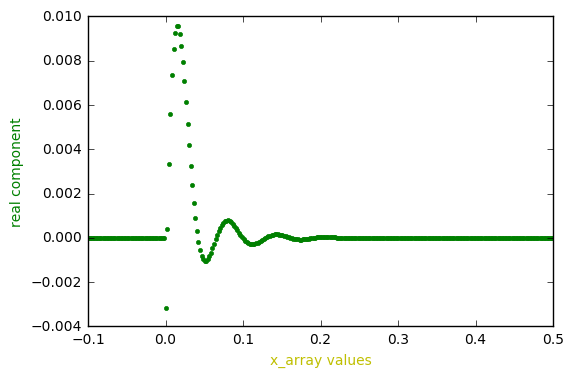

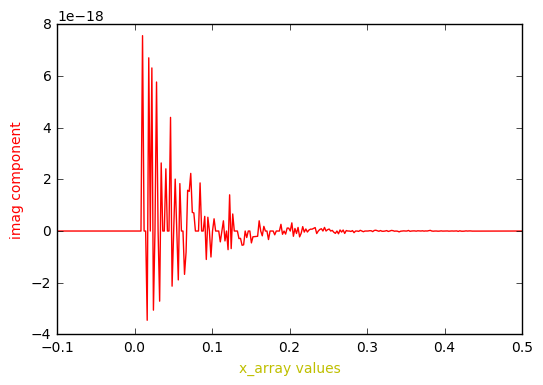

In [150]:
from scipy import integrate
sample_x_array = np.linspace(-0.1, 0.5, num=300, endpoint=True)
upsilon_M = 2**12
upsilon_space = np.linspace(-100, 100, num=upsilon_M+1, endpoint=True)

def F_minus_capital(x_point):
    if x_point < 0:
        return 0
    else:
        osc_exponent_power = 1j*x_point*upsilon_space
        osc_exponent = exp(osc_exponent_power)
        integrand = osc_exponent * integrand_minus(upsilon_space)  
        big_integral = integrate.simps(integrand, upsilon_space)
        weighted_big_integral =  exp(-1*x_point*omega_plus) * 1/(2*pi) * big_integral
        return weighted_big_integral

F_minus_capital_on_domain = np.array([F_minus_capital(x_point) for x_point in sample_x_array])
plt.plot(sample_x_array, F_minus_capital_on_domain.real, 'g.')
plt.xlabel('x_array values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(sample_x_array, F_minus_capital_on_domain.imag, 'r')
plt.xlabel('x_array values', color='y')
plt.ylabel('imag component', color='r')
plt.show()

Посчитаем другую функцию.

Вот что было сначала:
$$ F^+(x) = 1_{(-\infty, 0]}(x)(2\pi)^{-1} \int_{-\infty + i\omega_-}^{+\infty + i\omega_-} e^{ix\eta} \frac{ln(q+\psi(\eta))}{\eta^2} d\eta = $$
$$ F^+(x) = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix\upsilon} intfunc_+(\upsilon) d\upsilon $$

Вычислим значение подынтегральной части в виде: $$intfunc_+(\upsilon) = \frac{ln(q+\psi(\upsilon+i\omega_-))}{(\upsilon+i\omega_-)^2}, \upsilon \in \upsilon\_space$$

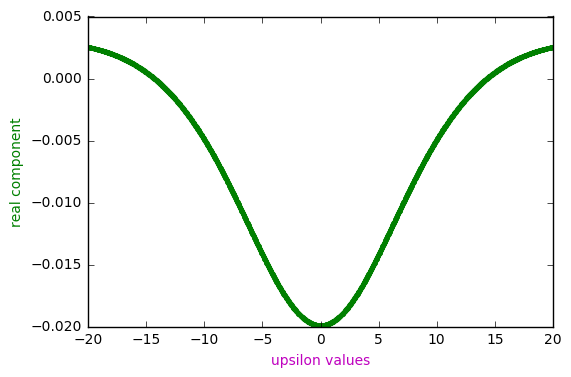

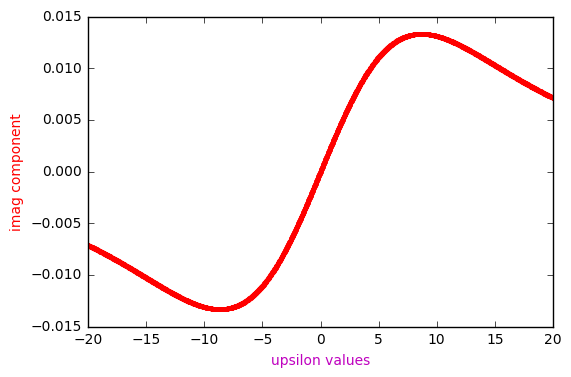

In [151]:
omega_minus = -15
def integrand_plus(upsilon_array):
    """
    принимает и возвращает массив длиной в степень двойки, исходя из логики дальнейшего использования
    """
    return np.array([log(q + psi(upsilon + 1j*omega_minus)) / (upsilon + 1j*omega_minus)**2 for upsilon in upsilon_array])

upsilon_M = 2**11
upsilon_space = np.linspace(-20.0, 20.0, num=upsilon_M, endpoint=False)

plt.plot(upsilon_space, integrand_plus(upsilon_space).real, 'g.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('real component', color='g')

plt.show()

plt.plot(upsilon_space, integrand_plus(upsilon_space).imag, 'r.')
plt.xlabel('upsilon values', color='m')
plt.ylabel('imag component', color='r')

plt.show()

Особую ценность имеет изучение интеграла от этой функции в нуле (к нему сводятся $F(0)$). Разделив значение на $2*\pi$ будем получать то, что мы надеемся увидеть у более изощрённых методов в точке 0

$$ F^+(0) = \frac{1}{2\pi} \int_{-\infty}^{+\infty} intfunc_+(\upsilon) d\upsilon $$

In [152]:
upsilon_space = np.linspace(-100, 100, num=upsilon_M+1, endpoint=True)
big_integral = (1/(2*pi))*integrate.simps(integrand_plus(upsilon_space), upsilon_space)
print(big_integral)

big_integral = (1/(2*pi))*integrate.trapz(integrand_plus(upsilon_space), upsilon_space)
print(big_integral)

(-0.00338379262962+0j)
(-0.00338379513405-8.83487411518e-18j)


Посчитаем методом Симпсона:
    
$$ F^+(x) = 1_{(-\infty, 0]}(x)e^{-x\omega_-}\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{ix\upsilon} intfunc_+(\upsilon) d\upsilon $$

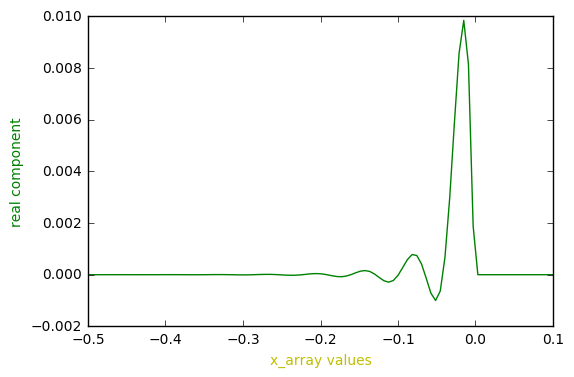

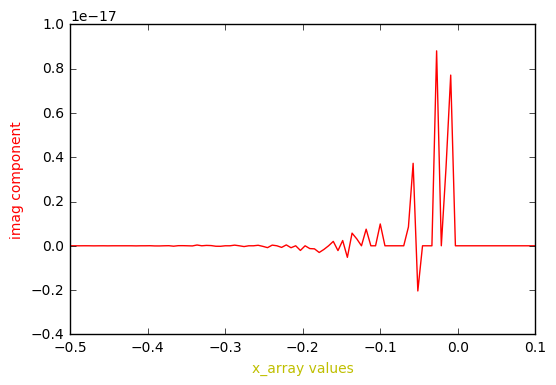

(-0.00338379262962+0j)


In [153]:
from scipy import integrate
sample_x_array = np.linspace(-0.5, 0.1, num=100, endpoint=True)
upsilon_M = 2**12
upsilon_space = np.linspace(-100, 100, num=upsilon_M+1, endpoint=True)

def F_plus_capital(x_point):
    if x_point > 0:
        return 0
    else:
        osc_exponent_power = 1j*x_point*upsilon_space
        osc_exponent = exp(osc_exponent_power)
        integrand = osc_exponent * integrand_plus(upsilon_space)  
        big_integral = integrate.simps(integrand, upsilon_space)
        weighted_big_integral =  exp(-1*x_point*omega_minus) * (1/(2*pi)) * big_integral
        return weighted_big_integral

F_plus_capital_on_domain = np.array([F_plus_capital(x_point) for x_point in sample_x_array])
plt.plot(sample_x_array, F_plus_capital_on_domain.real, 'g')
plt.xlabel('x_array values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(sample_x_array, F_plus_capital_on_domain.imag, 'r')
plt.xlabel('x_array values', color='y')
plt.ylabel('imag component', color='r')
plt.show()

print(F_plus_capital(0))

Теперь реализуем кусок в виде fft:
$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(\color{orange}{x})e^{-\color{orange}{x}\omega_+}\color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}\color{magenta}{\upsilon}} intfunc_-(\color{magenta}{\upsilon}) d\color{magenta}{\upsilon}} $$

Здесь возникает проблема, связанная с реализацией fft. Умножению на $e^{ix\xi}$ соответствует в numerical recipes прямое преобразование Фурье и соответствующее DFT. У нас же в определениях - обратное. По счастью, в библиотеке numpy придерживаются нашего подхода (вот документация, которая это подтверждает https://docs.scipy.org/doc/numpy/reference/routines.fft.html). Отличие только в том, что нужно учесть масштабирующий множитель.

Тогда $\color{magenta}{\upsilon}$, в которых вычисляется наша подынтегральная функция, будет относиться к домену частот. И возьмёт на себя роль, которую берёт $\color{magenta}{\xi}$ 

На вход нужно передать массив $\color{magenta}{intfunc(\upsilon)}$

<span style="color:red">Замечание</span>: Похоже, значения двойственной переменной лежат в промежутке $$[\frac{-\pi}{d}  \cdot\frac{1}{2\pi}, \frac{-\pi}{d} \cdot \frac{1}{2\pi})$$

Или, проще, $$[-1/2d, 1/2d)$$

Тем не менее, значения $\color{magenta}{\upsilon}$, в которых предполагается считать подынтегральную функцию, пришли из другой формы преобразования Фурье, где диапазон изменения переменной спектра таков: $$[-\pi/d, \pi/d)$$. Для того, чтобы привести значения к единой шкале, значения $\color{magenta}{\upsilon}$ нужно умножить на $2\pi$

9.53674316462e-08


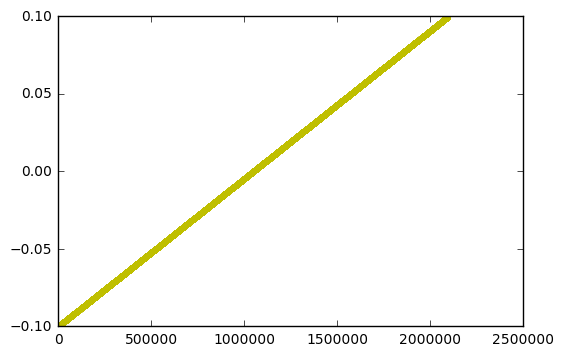

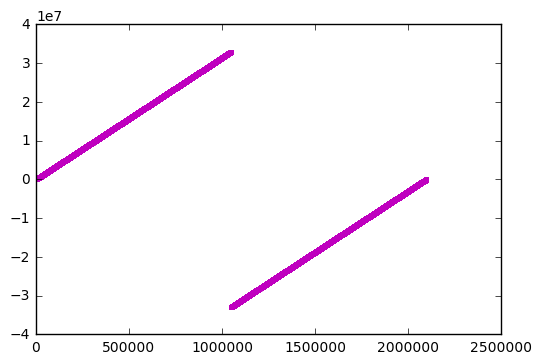

In [178]:
#пусть мой вывод будет нарисован от -1 до 1
#Там будет M точек
M = 2**21
x_space = np.linspace(-0.1, 0.1, num = M, endpoint=False)
# тогда интервал между точками (они распределены равномерно)
d = x_space[1] - x_space[0]
# соответствующие частоты получим при помощи функции
respective_upsilon_space = 2*pi*fft.fftfreq(M, d=d)
# проверим вывод
print(d)
plt.plot(x_space, 'y.')
plt.show()
plt.plot(respective_upsilon_space, 'm.')
plt.show()

Перейдём к интегралу
$$F^-(\color{orange}{x}) = 1_{[0,+\infty)}(\color{orange}{x})e^{-\color{orange}{x}\omega_+}\color{orange}{\frac{1}{2\pi}\int_{-\infty}^{+\infty} e^{i\color{orange}{x}\color{magenta}{\upsilon}} intfunc_-(\color{magenta}{\upsilon}) d\color{magenta}{\upsilon}} $$

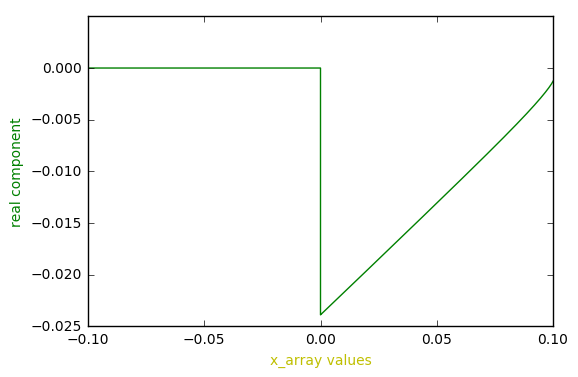

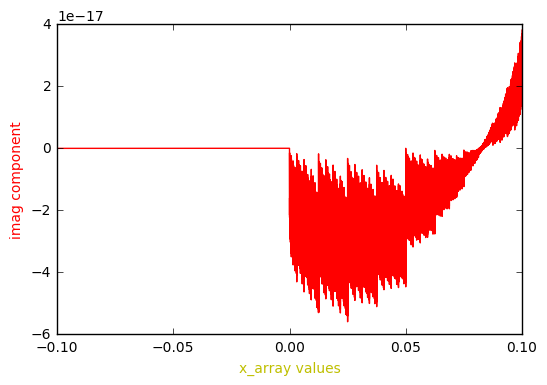

In [179]:
def F_minus_capital():
    # исходим из того, что x_array содержит M (то есть степень двойки) точек
    big_integral = fft.ifft(integrand_minus(respective_upsilon_space))
    # уберём масштабирующий множитель из библиотечного ifft за ненадобностью
    big_integral = M * big_integral    
    exp_powers = -1 * omega_plus * x_space
    exponent_factor = exp(exp_powers)
    weighted_big_integral = exponent_factor * big_integral
    indicator_array = np.where(np.array(x_space) >= 0, 1,0)
    return indicator_array * weighted_big_integral

filterdraw_left = np.where(np.array(x_space) >= -1, 1, np.nan)
filterdraw_right = np.where(np.array(x_space) < 2, 1, np.nan)

filterdraw =  filterdraw_left * filterdraw_right

plt.plot(x_space * filterdraw, filterdraw * F_minus_capital().real, 'g')
plt.xlabel('x_array values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(x_space * filterdraw, filterdraw * F_minus_capital().imag, 'r')
plt.xlabel('x_array values', color='y')
plt.ylabel('imag component', color='r')

plt.show()


In [170]:
indicator_array = np.where(np.array(x_space) >= 0, 1,0)
print(x_space[int(M/2+1)], indicator_array[int(M/2+1)])

1.1444091797e-06 1


# Конец разумной части

Для чистого Б-Ш, с бетами, вид такой

$$\phi^+_q(\xi) = \frac{\beta_+}{(\beta_+ - i2\pi\xi)}$$
$$\beta_+ = - \frac{(\gamma - \sqrt{(\gamma^2 + 2\sigma^2 q)})}{\sigma^2}$$


$\beta_+$ положительный корень уравнения $q+\psi(-i\beta)=0$

В случае БШ, если для F+ контур опускать вниз, до тех пор пока
он не дойдет до разреза логарифма (где в ноль обращается функция под логарифмом), затем вдоль разреза провести линии интегрирования, то получится вещественный интеграл  (рекомендую это сделать руками)

$$F+(х)=\int_{-\infty}^{-\beta_+}\frac{e^{-xz}}{z^2}dz, x<=0$$ 

Посмотрите на поведение этой функции и сравните с тем, что у Вас получается. Возможно, это интеграл очень быстро уходит в ноль. Т.е в окрестности х=0 нужно сделать мелкое разбиение, а сама область по х должна быть небольшой.

beta_plus =  44.2918588684
beta_minus =  -45.1980624647


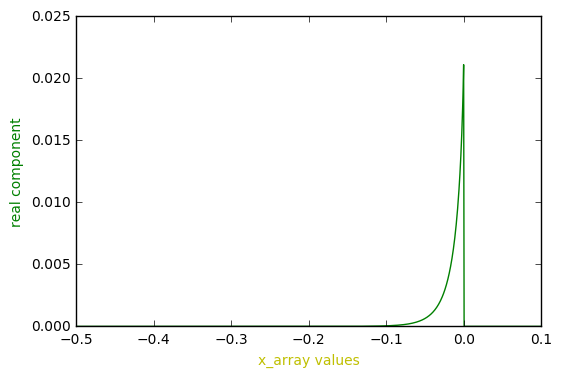

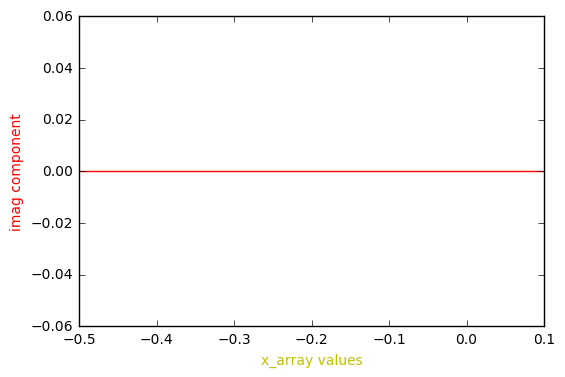

In [16]:
from scipy import integrate
sample_x_array = np.linspace(-0.5, 0.1, num=1000, endpoint=True)
M_z = 2**15

beta_plus = - (gamma - sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
print("beta_plus = ", beta_plus)
beta_minus = - (gamma + sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
print("beta_minus = ", beta_minus)

z_space = np.linspace(-1000*pi, -beta_plus, num=M_z, endpoint=True)
omega_minus = -1



def F_plus_capital(x_point):
    if x_point > 0:
        return 0
    else:
        exponent_power = - x_point * z_space
        exponent_factor = exp(exponent_power)
        z_space_factor = 1/ (z_space * z_space)
        integrand = exponent_factor * z_space_factor
        integral_value = integrate.simps(integrand, z_space)
        return integral_value

F_plus_capital_on_domain = np.array([F_plus_capital(x_point) for x_point in sample_x_array])

plt.plot(sample_x_array, F_plus_capital_on_domain.real, 'g')
plt.xlabel('x_array values', color='y')
plt.ylabel('real component', color='g')
plt.show()

plt.plot(sample_x_array, F_plus_capital_on_domain.imag, 'r')
plt.xlabel('x_array values', color='y')
plt.ylabel('imag component', color='r')
plt.show()

In [17]:
beta_plus = - (gamma - sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
print("beta_plus = ", beta_plus)
print("reciprocal = ", 1/beta_plus)

beta_minus = - (gamma + sqrt(gamma**2 + 2*sigma**2 * q))/sigma**2
print("beta_minus = ", beta_minus)
print("reciprocal = ", 1/beta_minus)

beta_plus =  44.2918588684
reciprocal =  0.0225775125621
beta_minus =  -45.1980624647
reciprocal =  -0.0221248422049
